# Demo 6: SVM for MNIST Digit Recognition

Modified from Prof Rangan's demo.

In this demo, you will learn to:
* Load and display images from http://yann.lecun.com/exdb/mnist/ 
* Formulate image classification problems
* Explain the limitations of linear classifiers for image classification
* Build a simple SVM image classifier 
* Save and load results using `pickle`.

For data, we will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set used to recognize hand-written digits.  The dataset was originally produced in the 1980s and is now widely-used in machine learning classes as a simple image classification problem.  

## Loading the Data

First, we load the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Since the MNIST dataset is so widely-used, the `sklearn` module has the dataset built in.  It can be loaded as follows.  We see that the data is stored in an array with 1787 images, each 8 x 8.

In [2]:
from sklearn import datasets, linear_model, preprocessing
digits = datasets.load_digits()
images = digits.images
labels = digits.target
images.shape

(1797, 8, 8)

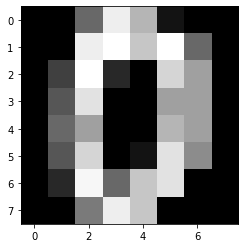

In [3]:
# It is easier to see the actual data when it is only 8x8 instead of 28x28
plt.imshow(images[0],  cmap='Greys_r')

The above is fairly low-resolution.  We can get a more high-resolution 28 x 28 image data from the following command.  But, this will take a few minutes to load for some reason.  In this data format, each image is stored as a 784 = 28x28 row vector.

In [4]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [5]:
X.data.shape

(70000, 784)

In [6]:
#splitting the training data
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.52, random_state=0)

We have 70000 image.  Each image is `28 x 28`, which is stored as a 784 pixel vector.  The following code plots a digit.  To do this, it reshapes the 784 dim vector to a `28 x 28` array and then uses the `plt.imshow` command.  

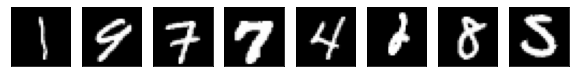

In [7]:
def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])
    

# Select random digits
nplt = 8
ntr = Xtr.shape[0]
Iperm = np.random.permutation(ntr)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt,figsize=(10,3))
for i in range(nplt):
    ind = Iperm[i]
    plt_digit(ax[i], Xtr[ind,:])


## Trying a Logistic Regression Classifier

To classify the digits, we will first use a logistic classifier.  
The optimizer is very slow.  

Now we run the optimizer.  I have placed the `verbose=10` option so that you can see the progress.  It may not appear in the browser but in the command line where you launched jupyter notebook.  This can take several minutes and will likely say that it ran out of iterations.

In [8]:
logreg = linear_model.LogisticRegression(multi_class='multinomial', 
                                         solver='sag', max_iter=400)
logreg.fit(Xtr,ytr)

/Users/lindasellie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=400, multi_class='multinomial', solver='sag')

Now, we can measure the accuracy on the test data.

In [9]:
yhat = logreg.predict(Xts)
acc = np.mean(yhat == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.907088


This sounds Ok.  Can we imporve it?

Let's plot some of the errors.  

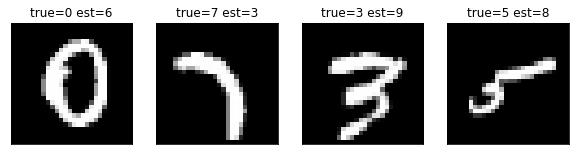

In [10]:

nplt = 4
Ierr = np.where(yts != yhat)[0]

fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):        
    ind = Ierr[i]    
    plt_digit(ax[i], Xts[ind,:])        
    title = 'true={0:s} est={1:s}'.format(yts[ind], yhat[ind])
    ax[i].set_title(title)

Obviously, some of these digits are very easy to classify for a human.  We can get more fine-grained analysis of the digit errors by computing the confusion matrix.

[[0.952 0.    0.006 0.002 0.002 0.014 0.012 0.003 0.009 0.002]
 [0.001 0.972 0.006 0.004 0.002 0.003 0.001 0.002 0.012 0.002]
 [0.009 0.009 0.888 0.016 0.016 0.003 0.014 0.013 0.028 0.003]
 [0.006 0.006 0.029 0.88  0.002 0.037 0.003 0.009 0.021 0.013]
 [0.004 0.003 0.008 0.004 0.916 0.001 0.012 0.008 0.008 0.033]
 [0.012 0.004 0.01  0.036 0.014 0.841 0.018 0.003 0.035 0.013]
 [0.008 0.003 0.014 0.001 0.012 0.013 0.94  0.002 0.008 0.   ]
 [0.001 0.005 0.015 0.005 0.012 0.003 0.    0.917 0.005 0.039]
 [0.009 0.016 0.015 0.027 0.006 0.038 0.012 0.002 0.856 0.016]
 [0.005 0.004 0.004 0.012 0.035 0.005 0.001 0.029 0.01  0.894]]


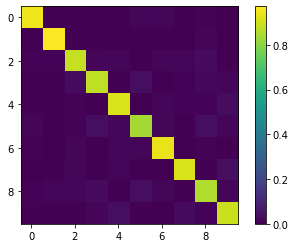

In [11]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[None,:]

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

## Visualizing the Weights

To see the problem with the logistic classifier, it is useful to plot the weights for each digit.  

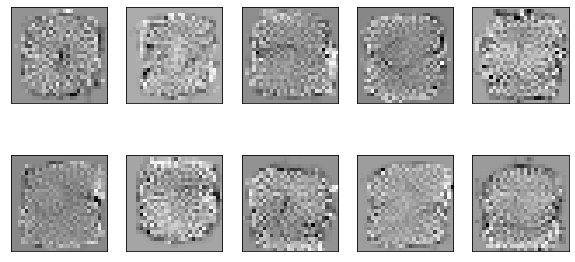

In [12]:

W = logreg.coef_
ndigit = W.shape[0] #how many digits
fig, ax = plt.subplots(2,5,figsize=(10, 5))
for i in range(ndigit): # loop through each digit
    irow = i // 5
    icol = i % 5
    plt_digit(ax[irow,icol], W[i,:])

What you see is that each weight is a very blurry version of the digit.  The blurriness is due to the fact that weight must correlate with all shifts, rotations and other variations of the digits.  As a result, the weights begin to correlate with other incorrect digits leading to poor performance.




## Run an SVM classifier

We now try an SVM classifier.  The parameters are given by 

https://martin-thoma.com/svm-with-sklearn/

This website has a nice summary of the main equations for SVM as well.  That site trained on 40000 samples and tested on 20000.  But, to make this run faster, we will train on 10000 and test on 10000.  If you increase to 40000 training samples, you can get past 99% accuracy.

First, we import the SVM package and construct the SVC with the parameters.

In [13]:
from sklearn import svm

# Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,  kernel="linear",verbose=10)


We fit the training data.  Again, this will take several minutes.

In [14]:
svc.fit(Xtr,ytr)

[LibSVM]

SVC(kernel='linear', verbose=10)

Measure the accuracy on the test data.  The prediction can take several minutes too -- SVMs are *very* slow!

In [15]:
yhat_ts = svc.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.910000


You should get an accuracy of around 91%-93%.  Again, had you trained on all 50,000 samples, it would have been much better -- close to 98.5%.  But, even this result is  better than logistic regression.

Since even the prediction (sometimes called inference) is slow with SVMs, we will save the results in `pickle` file.

Plot some errors

<Figure size 720x288 with 0 Axes>

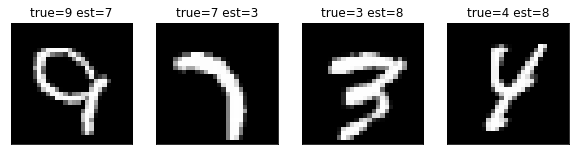

In [16]:
Ierr = np.where((yhat_ts != yts))[0]
nplt = 4
plt.figure(figsize=(10, 4))


fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):        
    ind = Ierr[i]    
    plt_digit(ax[i], Xts[ind,:])        
    title = 'true={0:s} est={1:s}'.format(yts[ind], yhat_ts[ind])
    ax[i].set_title(title)

We see that again a human would not have made these errors, but the digits in error are much less clear.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about 5000 support vectors.  So, about half the training samples were used as SVs.  This is partly why the prediction was so slow.

In [17]:
S = svc.support_vectors_
S.shape

(5888, 784)

We can plot some of the vectors.

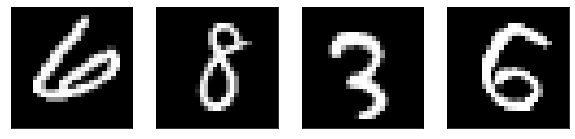

In [18]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
  
    
fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):
    ind = Iperms[i]    
    plt_digit(ax[i], S[ind,:])        


## We can also see how well a RBF kernel performs on the data

In [19]:
svc_rbf = svm.SVC(probability=False,  kernel="rbf", verbose=10)
svc_rbf.fit(Xtr,ytr)

[LibSVM]

SVC(verbose=10)

In [20]:
yhat_ts = svc_rbf.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.973297


### On your own, try different hyperparamters and a polynomial kernel.